# 🎵 Music Genre Classification

This notebook presents a machine learning pipeline for classifying music genres using Support Vector Machines (SVM) with One-vs-Rest and One-vs-One strategies.

We use the GTZAN dataset and audio features (MFCC). The model used is RBF Binary Kernel SVM with both multiclass classification strategies One-vs-Rest and One-vs-One.


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os

import courselib.utils.loaders as loaders
from courselib.utils.splits import train_test_split
from sklearn.preprocessing import StandardScaler
from courselib.models.multiclass_svm import KernelMulticlassOvR
from courselib.models.multiclass_svm import KernelMulticlassOvO
from courselib.utils.metrics import confusion_matrix
from courselib.utils.preprocessing import labels_to_numbers
from courselib.models.nn import MLP
from courselib.optimizers import GDOptimizer


# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

config = {
    "C": 1.0,
    "kernel": "rbf",
    "random_seed": 42,
    "training_data_fraction": 0.8,
    "layer_widths": [40, 128, 64, 10],
    "gdoptimizer_learning_rate": 0.01,
    "activation": "ReLU",
    "output_activation": "Softmax",
    "loss": "CE",
    "epochs": 50,
}

np.random.seed(config["random_seed"])
random.seed(config["random_seed"])

### Loading
 
The GTZAN dataset has data in 2 formats:
1. 30s fragments of each song
2. Each fragment from 1. is split into 10 segments with 3s length

We will work with the 30s file.

In [2]:
df = loaders.load_music_30_sec()
#df = loaders.load_music_3_sec()

class_names = sorted(df["label"].unique().tolist())

Loading from `features_30_sec.csv`...


### Train-Test Split

We will train the models on all MFCC features and do the train-test split proportion 80/20.

In [3]:
# Extract only MFCC columns from df
mfcc_columns = [col for col in df.columns if col.startswith('mfcc')]
features = mfcc_columns + ['label']

# Do train test split
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(
    df[features],
    training_data_fraction=config["training_data_fraction"],
    class_column_name='label',
    shuffle=True,
    return_numpy=True
)

print('Training data split as follows:')
print(f'  Training data samples: {len(X_train)}')
print(f'      Test data samples: {len(X_test)}')

Training data split as follows:
  Training data samples: 800
      Test data samples: 200


## Preprocessing

We standardize our features using z-score normalization. This step rescales all features to have zero mean and unit variance.

We also compute a reasonable value for the kernel width parameter $\sigma$ using the *median heuristic*:
$$
\sigma = \sqrt{ \frac{ \text{median}( \| x_i - x_j \|^2 ) }{2} }
$$

This tunning was done because of low accuracy on not preprocessed data.

In [4]:
# Standardize features (z-score)
scaler = StandardScaler().fit(X_train)
X_train_z = scaler.transform(X_train)
X_test_z  = scaler.transform(X_test)

# Compute kernel width using median heuristic (for RBF kernel)
subset = X_train_z[np.random.choice(len(X_train_z), 500, replace=False)]
d2 = np.sum((subset[:, None, :] - subset[None, :, :])**2, axis=-1)
sigma = np.sqrt(0.5 * np.median(d2[d2 > 0]))  # avoid zero distances

X_train = X_train_z
X_test = X_test_z

### OvR model

First we train the OvR classification strategy with the RBF Binary Kernel SVM model.

Then evaluate the performance ovr the test data. Both single model as well as overall performance statistics are calculated.

In [5]:
svmOvR = KernelMulticlassOvR(kernel=config["kernel"], sigma=sigma, C=config["C"])
svmOvR.fit(X_train, Y_train)

🎯 Overall accuracy (OvR): 68.5000 %
📊 Accuracy of each binary model (One-vs-Rest):
  - Class 'blues': 91.0000
  - Class 'classical': 98.5000
  - Class 'country': 91.5000
  - Class 'disco': 91.0000
  - Class 'hiphop': 90.0000
  - Class 'jazz': 92.0000
  - Class 'metal': 97.5000
  - Class 'pop': 96.0000
  - Class 'reggae': 90.5000
  - Class 'rock': 94.5000


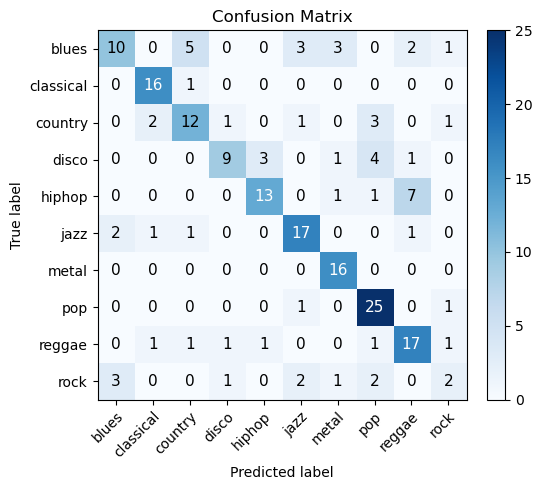

In [6]:
svmOvR.evaluate_accuracy(X_test, Y_test)
svmOvR.evaluate_models(X_test, Y_test)

true_labels = np.eye(10)[labels_to_numbers(Y_test, class_names=class_names)]
pred_labels = np.eye(10)[labels_to_numbers(svmOvR(X_test), class_names=class_names)]

confusion_matrix(true_labels, pred_labels, num_classes=10, class_names=class_names)

### OvO model

First we train the OvO classification strategy with the RBF Binary Kernel SVM model.

Then evaluate the performance ovr the test data. Both single model as well as overall performance statistics are calculated.

In [7]:
svmOvO = KernelMulticlassOvO(kernel=config["kernel"], sigma=sigma, C=config["C"])
svmOvO.fit(X_train, Y_train)

🎯 Overall accuracy (OvO): 71.0000 %
📊 Accuracy of each OvO binary classifier:
  - Classifier 'blues' vs 'classical': 97.5610
  - Classifier 'blues' vs 'country': 81.8182
  - Classifier 'blues' vs 'disco': 100.0000
  - Classifier 'blues' vs 'hiphop': 97.8261
  - Classifier 'blues' vs 'jazz': 89.1304
  - Classifier 'blues' vs 'metal': 92.5000
  - Classifier 'blues' vs 'pop': 100.0000
  - Classifier 'blues' vs 'reggae': 91.4894
  - Classifier 'blues' vs 'rock': 85.7143
  - Classifier 'classical' vs 'country': 94.5946
  - Classifier 'classical' vs 'disco': 97.1429
  - Classifier 'classical' vs 'hiphop': 100.0000
  - Classifier 'classical' vs 'jazz': 89.7436
  - Classifier 'classical' vs 'metal': 100.0000
  - Classifier 'classical' vs 'pop': 100.0000
  - Classifier 'classical' vs 'reggae': 95.0000
  - Classifier 'classical' vs 'rock': 96.4286
  - Classifier 'country' vs 'disco': 84.2105
  - Classifier 'country' vs 'hiphop': 100.0000
  - Classifier 'country' vs 'jazz': 88.0952
  - Classifier

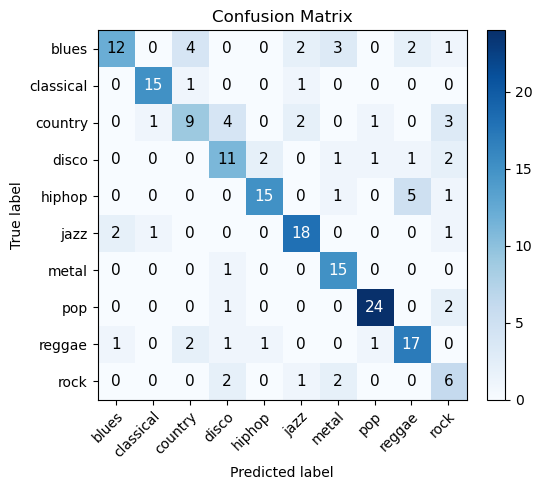

In [8]:
svmOvO.evaluate_accuracy(X_test, Y_test)
svmOvO.evaluate_models(X_test, Y_test)

true_labels = np.eye(10)[labels_to_numbers(Y_test, class_names=class_names)]
pred_labels = np.eye(10)[labels_to_numbers(svmOvO(X_test), class_names=class_names)]

confusion_matrix(true_labels, pred_labels, num_classes=10, class_names=class_names)

MLP model

In [9]:
Y_test_encoded = np.eye(10)[labels_to_numbers(Y_test, class_names=class_names)]
Y_train_encoded = np.eye(10)[labels_to_numbers(Y_train, class_names=class_names)]

In [10]:
model = MLP(
    widths=config["layer_widths"],  # input size 40, two hidden layers, output size 10
    optimizer=GDOptimizer(learning_rate=config["gdoptimizer_learning_rate"]),
    activation=config["activation"],
    output_activation=config["output_activation"],
    loss=config["loss"]
)

In [13]:
metrics_dict = {
    "accuracy": lambda Y_pred, Y_true: np.mean(np.argmax(Y_pred, axis=1) == np.argmax(Y_true, axis=1))
}

metrics_history = model.fit(X_train, Y_train_encoded, num_epochs=config["epochs"], batch_size=128, compute_metrics=True, metrics_dict=metrics_dict)

In [15]:
for metric in metrics_history:
        if metric in metrics_history:
            metrics_history[metric].extend(metrics_history[metric])
        else:
            metrics_history[metric] = metrics_history[metric]

# Evaluate on test set
test_acc = metrics_dict["accuracy"](model.decision_function(X_test), Y_test_encoded)
print(f"Train accuracy: {metrics_history['accuracy'][-1]*100:.2f}% | "
        f"Test accuracy: {test_acc*100:.2f}%")

Train accuracy: 17.75% | Test accuracy: 16.50%
